In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
import os

In [2]:
data_dir = '/scratch/aew492/research-summer2020_output'

In [3]:
def load_suave_amps(cat_tag, rlzs=401, m=1.0, b=0.5, basis='bao_fixed', grad_dir=os.path.join(data_dir, 'gradient/1D')):
    amps = np.empty((rlzs,4))
    for rlz in range(rlzs):
        suave_dict = np.load(os.path.join(grad_dir, f'suave_data/{cat_tag}/{basis}/{cat_tag}_rlz{rlz}_m-{m}00-L_b-{b}00.npy'), allow_pickle=True).item()
        amps[rlz] = suave_dict['amps']
    return amps

In [4]:
def std_grad(V, n, P):
    std = P * (V**(-.5) * (1 + (n*P)**(-1))) * (V**(-1/3))  # last factor is from position dependence across box
    return std

In [5]:
def std_cf(V, n, P):
    std = P * (V**(-.5) * (1 + (n*P)**(-1)))
    return std

In [6]:
def get_cfarr_vals(cf_arr):
    arr_len = len(cf_arr[0])
    cfs_mean = np.zeros(arr_len)
    stds = np.zeros(arr_len)
    error_regions = np.empty((arr_len, 2))
    for i in range(arr_len):
        mean, std = np.mean(cf_arr[:,i]), np.std(cf_arr[:,i])
        cfs_mean[i] = mean
        stds[i] = std
        error_regions[i] = [mean-std, mean+std]
    return cfs_mean, stds, error_regions

### load in input power spectrum

In [7]:
kG, PkG = np.loadtxt(f'/scratch/ksf293/mocks/lognormal/inputs/cat_L750_n1e-4_z057_patchy_As2x_pkG.dat').T

In [8]:
# let's naively take the value of xi at r=40
r_rep = 40
k_rep = 1/r_rep
k_rep = min(kG, key=lambda x:abs(x-k_rep))  # closest r value to 40
P_rep = PkG[np.where(kG==k_rep)]
k_rep, P_rep

(0.02511886432, array([76730.64364]))

### spread of $a_0$ from CFE

In [9]:
Ls = ['500', '750', '1000']
ns = ['1e-4', '2e-4']

In [10]:
amp_data = []

for L in Ls:
    for i, n in enumerate(ns):
        cat_tag = f'L{L}_n{n}_z057_patchy_As2x'
        amps = load_suave_amps(cat_tag)
        a0s = amps[:,0]
        std = np.std(a0s)
        amp_dict = {
            'L' : L,
            'n' : n,
            'cat_tag' : cat_tag,
            'amps' : amps,
            'a0s' : a0s,
            'std' : std
        }
        amp_data.append(amp_dict)

In [11]:
spread_a0_n1 = []
spread_a0_n2 = []
for data in amp_data:
    if data['n'] == '1e-4':
        spread_a0_n1.append(data['std'])
    elif data['n'] == '2e-4':
        spread_a0_n2.append(data['std'])

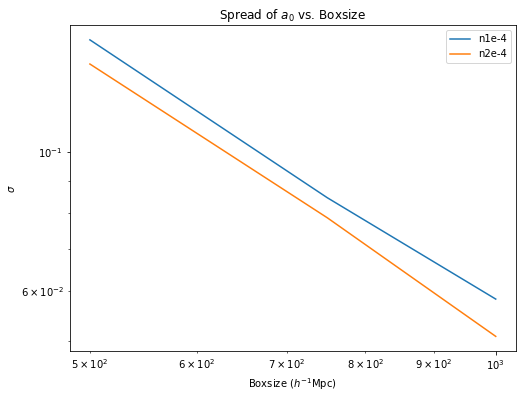

In [12]:
fig, ax = plt.subplots(figsize=(8,6))

Ls = [float(L) for L in Ls]

ax.plot(Ls, spread_a0_n1, label='n1e-4')
ax.plot(Ls, spread_a0_n2, label='n2e-4')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Boxsize ($h^{-1}$Mpc)')
ax.set_ylabel('$\sigma$')
ax.set_title('Spread of $a_0$ vs. Boxsize')
ax.legend()

### plot suave for many mocks

In [13]:
cat_tag

'L1000_n2e-4_z057_patchy_As2x'

In [14]:
basis = 'bao_fixed'
m = 1.0
b = 0.5
rlz = 0

In [15]:
suave_info = np.load(os.path.join(data_dir, f'gradient/1D/suave_data/{cat_tag}/{basis}/{cat_tag}_rlz{rlz}_m-{m:.3f}-L_b-{b:.3f}.npy'), allow_pickle=True).item()
suave_info.keys()

dict_keys(['grad_recovered', 'mean_sq_err', 'r_avg', 'amps', 'r_fine', 'xi_locs', 'proj_type', 'projfn', 'weight_type'])

In [16]:
def plot_suave_cf(rlzs, cat_tag, basis='bao_fixed', m=1.0, b=0.5, grad_dir=os.path.join(data_dir, 'gradient/1D'), color=None, ymin=None, ymax=None, label=None):
    mock_info = np.load(os.path.join(grad_dir, f'mock_data/{cat_tag}/{cat_tag}_rlz{rlzs[0]}_m-{m:.3f}-L_b-{b:.3f}.npy'), allow_pickle=True).item()
    L = mock_info['boxsize']
    
    fig, ax = plt.subplots(figsize=(8,8))
    
    for i, rlz in enumerate(rlzs):
        label = None if i else label
        suave_info = np.load(os.path.join(grad_dir, f'suave_data/{cat_tag}/{basis}/{cat_tag}_rlz{rlz}_m-{m:.3f}-L_b-{b:.3f}.npy'), allow_pickle=True).item()
        r_fine = suave_info["r_fine"]
        xi_locs = suave_info["xi_locs"]

        ax.plot(r_fine, xi_locs[len(xi_locs)//2], color=color)
        ax.fill_between(r_fine, xi_locs[0], xi_locs[len(xi_locs)-1], color=color, alpha=0.1, label=label)
    
    ax.axhline(0, color='grey', lw=0.5)
    ax.set_ylim((ymin, ymax))
    ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
    ax.set_ylabel(r'correlation function $\xi(r)$')
    
    return fig, ax

In [17]:
cat_tag = 'L750_n4e-4_z057_patchy_As2x'
nmocks = 20
rlzs = range(nmocks)

In [18]:
a0s = np.zeros(nmocks)
for rlz in range(nmocks):
    suave_info = np.load(os.path.join(data_dir, f'gradient/1D/suave_data/{cat_tag}/bao_fixed/{cat_tag}_rlz{rlz}_m-{m:.3f}-L_b-{b:.3f}.npy'), allow_pickle=True).item()
    a0s[rlz] = suave_info['amps'][0]

In [19]:
# fixed basis
r_basis, basis = np.loadtxt(os.path.join(data_dir, 'bases/bao_fixed/cosmo_basis.dat')).T
basis.shape

(2000,)

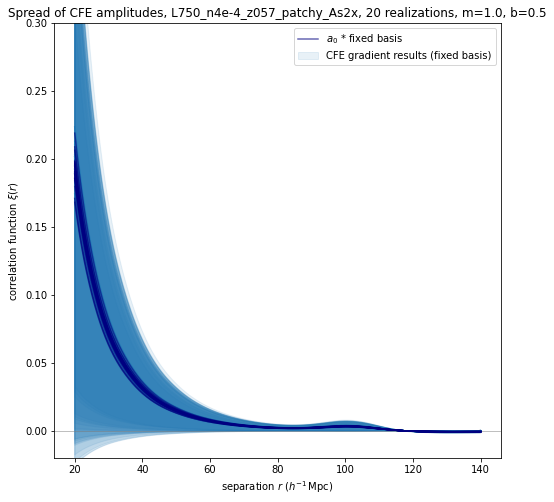

In [20]:
fig, ax = plot_suave_cf(rlzs, cat_tag, m=1, color='C0', ymax=0.3, ymin=-0.02, label='CFE gradient results (fixed basis)')

cf_fids = np.empty((len(a0s), len(basis)))
for i, a0 in enumerate(a0s):
    cf_fid = a0*basis
    label = None if i else '$a_0$ * fixed basis'
    ax.plot(r_basis, cf_fid, color='navy', alpha=0.6, label=label)
    cf_fids[i] = cf_fid
ax.set_title(f'Spread of CFE amplitudes, {cat_tag}, {nmocks} realizations, m={m:.1f}, b={b:.1f}')
ax.legend()

In [21]:
mean_cfecf = np.mean(cf_fids, axis=0)
stds_cfecf = np.std(cf_fids, axis=0)
stds_cfecf.shape

(2000,)

In [22]:
nbins = 22
cf_arr = np.empty((nmocks,nbins))
for i in range(nmocks):
    r_ls, xi_ls = np.load(os.path.join(data_dir, f'gradient/1D/ls/{cat_tag}/xi_ls_3x_{cat_tag}_rlz{i}_m-{m:.3f}-L_b-{b:.3f}.npy'), allow_pickle=True)
    cf_arr[i] = xi_ls

In [23]:
cfs_mean_ls, stds_ls, error_regions_ls = get_cfarr_vals(cf_arr)

Text(0, 0.5, '$\\xi$(r)')

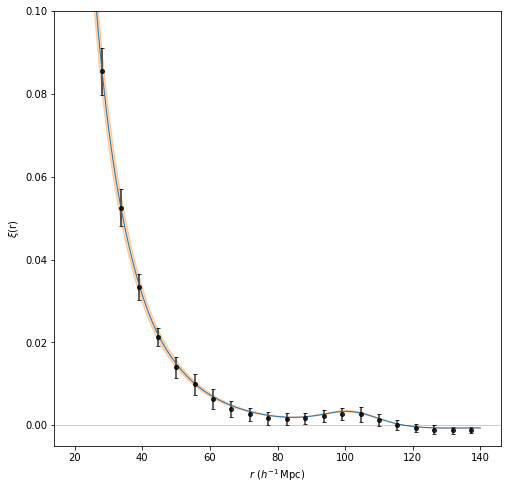

In [24]:
fig, ax = plt.subplots(figsize=(8,8))

ax.errorbar(r_ls, cfs_mean_ls, yerr=stds_ls, color='k', alpha=0.8, fmt='o', markersize=4, capsize=2, label=f'L-S lognormal')

ax.plot(r_basis, mean_cfecf, color='C0', lw=1)
ax.fill_between(r_basis, mean_cfecf-stds_cfecf, mean_cfecf+stds_cfecf, color='C1', alpha=0.3)

ax.set_ylim((-0.005,0.1))
ax.axhline(0, color="k", alpha=0.2, lw=1)
ax.set_xlabel(r'$r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'$\xi$(r)')

In [25]:
r_rep = 50
r_rep_cfe = min(r_basis, key=lambda x:abs(x-r_rep))
r_rep_ls = min(r_ls, key=lambda x:abs(x-r_rep))

In [32]:
std_ls_rep = stds_ls[np.where(r_ls==r_rep_ls)]
std_cfe_rep = stds_cfecf[np.where(r_basis==r_rep_cfe)]

In [35]:
print(f'{std_ls_rep[0]:.6f}, {std_cfe_rep[0]:.6f}')

0.002567, 0.000900


In [28]:
mean_std_ls = np.mean(stds_ls)
mean_std_cfe = np.mean(stds_cfecf)

In [36]:
print(f'{mean_std_ls:.6f}, {mean_std_cfe:.6f}')

0.002263, 0.001106


In [30]:
median_std_ls = np.median(stds_ls)
median_std_cfe = np.median(stds_cfecf)
median_std_ls, median_std_cfe

(0.0015665173633789247, 0.00018780673006506856)

In [ ]:
print(f'{median_std_ls:.6f}, {median_std_cfe:.6f}')